# Week 02 - Deep Learning Repetition

## Data Augmentation

Even though the metrics looked quite good in the basic model, the performance of classifying custom hand-written digits was sub-optimal.

In this notebook, we address this issue by performing **data augmentation** on the dataset to account for variations such as rotations, different pencil shapes, blurs, and more.

These modifications should improve the model's ability to recognize custom hand-written digits. 📝

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import sklearn.metrics
from tqdm.notebook import tqdm
from pathlib import Path
import shutil
import onnxruntime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device.upper()}")

Using CPU


## Load the MNIST Dataset 

### Data Augmentation

There are a few options to augment the image data:

- Randomly crop the image: RandomCrop(Output Image Size, Padding of the Image)

    `torchvision.transforms.RandomCrop(28, 4)`

- Randomly rotate the image: RandomRotation(Max Rotation in Degrees)

    `torchvision.transforms.RandomRotation(5)`

- Randomly blur the image: GaussianBlur(Kernel Size) -> larger kernel means more blur

    `torchvision.transforms.GaussianBlur(kernel_size = (5,5))`

- Randomly change the colors in the image: ColorJitter(Brightness, Contrast, Saturation, Hue)

    `torchvision.transforms.ColorJitter(brightness=(0.5,1.5), contrast=3, saturation=(0.3,1.5), hue=(-0.1,0.1))`


In [2]:
# Define the transformation
image_transformation = transforms.Compose(
    [
        # '''TODO: Insert data augmentation here.'''
        transforms.GaussianBlur(kernel_size=(5, 5)),
        transforms.RandomRotation(15),
        transforms.RandomCrop(28, 4),
        transforms.ColorJitter(
            brightness=(0.5, 1.5), contrast=3, saturation=(0.3, 1.5), hue=(-0.1, 0.1)
        ),
        transforms.ToTensor(),
    ]
)

In [3]:
mnist_directory = Path.cwd() / ".mnist_data" / "2_augmented"

# Delete the existing MNIST data directory if it exists
if mnist_directory.exists() and mnist_directory.is_dir():
    shutil.rmtree(mnist_directory)

In [4]:
# Load the MNIST dataset
dataset_mnist_train = datasets.MNIST(
    mnist_directory, train=True, download=True, transform=image_transformation
)
dataset_mnist_test = datasets.MNIST(
    mnist_directory, train=False, download=True, transform=image_transformation
)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.78MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 316kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


Split the training dataset into training and validation sets using PyTorch's `random_split` function.

In [5]:
# Split the training dataset into training and validation sets
train_size = int(0.8 * len(dataset_mnist_train))
val_size = len(dataset_mnist_train) - train_size
dataset_mnist_train, dataset_mnist_val = random_split(
    dataset_mnist_train, [train_size, val_size]
)

The `DataLoader` class is useful to create batch sizes of the data and to shuffle it.

In [6]:
# Create DataLoaders
train_loader = DataLoader(dataset_mnist_train, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset_mnist_val, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset_mnist_test, batch_size=64, shuffle=True)

## Visualize the Dataset

Let us briefly look at the data 👀

In [7]:
images, labels = next(iter(train_loader))

print(f"Image Batch shape: {images.shape}")
print(f"Label Batch shape: {labels.shape}")

Image Batch shape: torch.Size([64, 1, 28, 28])
Label Batch shape: torch.Size([64])


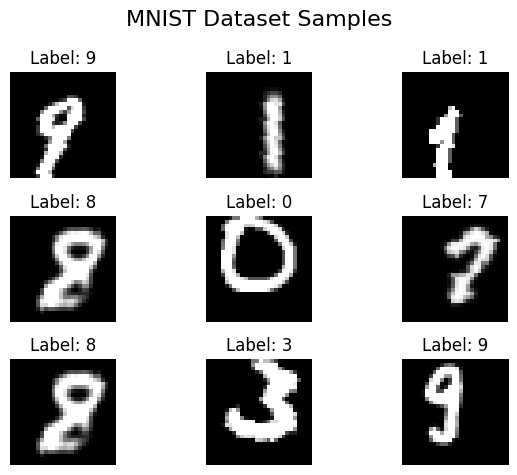

In [8]:
fig, axes = plt.subplots(3, 3)
fig.suptitle("MNIST Dataset Samples", fontsize=16)

for ax in axes.flat:
    idx = torch.randint(0, len(images), (1,))
    ax.imshow(images[idx].squeeze(), cmap="gray")
    ax.set_title(f"Label: {labels[idx].item()}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Model Architecture

We still use the same simple CNN to better compare the results (change one thing at a time).

In [9]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=4 * 14 * 14, out_features=10),
)

In [10]:
print(summary(model=model, input_size=images.shape))
model_output = model(images)
print(f"Model output shape: {model_output.shape}")

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 4, 28, 28]           40
├─ReLU: 1-2                              [64, 4, 28, 28]           --
├─MaxPool2d: 1-3                         [64, 4, 14, 14]           --
├─Flatten: 1-4                           [64, 784]                 --
├─Linear: 1-5                            [64, 10]                  7,850
Total params: 7,890
Trainable params: 7,890
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.51
Input size (MB): 0.20
Forward/backward pass size (MB): 1.61
Params size (MB): 0.03
Estimated Total Size (MB): 1.84
Model output shape: torch.Size([64, 10])


## Model Training

Training Epoch 1/1:   0%|          | 0/750 [00:00<?, ?it/s]

After batch 100: Train Loss: 2.0819


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 100: Validation Loss: 1.8538
After batch 200: Train Loss: 1.9326


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 200: Validation Loss: 1.7560
After batch 300: Train Loss: 1.8624


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 300: Validation Loss: 1.6751
After batch 400: Train Loss: 1.8078


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 400: Validation Loss: 1.5900
After batch 500: Train Loss: 1.7617


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 500: Validation Loss: 1.5736
After batch 600: Train Loss: 1.7267


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 600: Validation Loss: 1.5213
After batch 700: Train Loss: 1.6958


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 700: Validation Loss: 1.4934
Epoch 1 - Train Loss: 1.6831


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 - Validation Loss: 1.4659


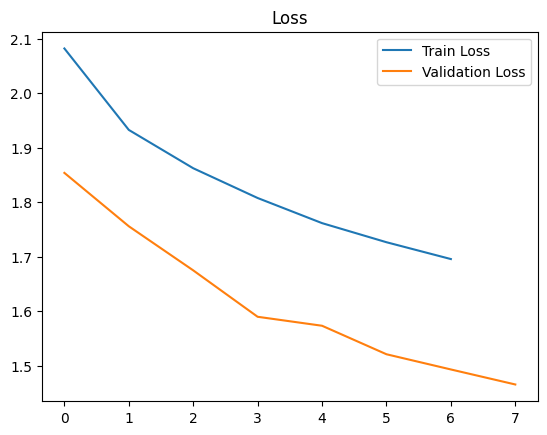

In [11]:
EPOCHS = 1
LEARNING_RATE = 0.001
BATCH_INTERVAL = 100  # Calculate losses after every 100 batches

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

train_loss_history = []
val_loss_history = []

model.to(device)

for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0
    for batch_idx, (image_batch, output_batch) in enumerate(
        tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS}"), start=1
    ):
        image_batch, output_batch = image_batch.to(device), output_batch.to(device)
        optimizer.zero_grad()
        model_output = model(image_batch)
        loss = loss_function(model_output, output_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        if (batch_idx) % BATCH_INTERVAL == 0:
            avg_train_loss = running_train_loss / (batch_idx)
            train_loss_history.append(avg_train_loss)
            print(f"After batch {batch_idx}: Train Loss: {avg_train_loss:.4f}")

            # Evaluate validation loss
            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for val_image_batch, val_output_batch in tqdm(
                    val_loader, desc="Validation"
                ):
                    val_image_batch, val_output_batch = (
                        val_image_batch.to(device),
                        val_output_batch.to(device),
                    )
                    val_model_output = model(val_image_batch)
                    val_loss = loss_function(val_model_output, val_output_batch)
                    running_val_loss += val_loss.item()
            avg_val_loss = running_val_loss / len(val_loader)
            val_loss_history.append(avg_val_loss)
            print(f"After batch {batch_idx}: Validation Loss: {avg_val_loss:.4f}")
            model.train()  # Switch back to training mode

    avg_epoch_train_loss = running_train_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Train Loss: {avg_epoch_train_loss:.4f}")

    # Evaluate validation loss at the end of each epoch
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_image_batch, val_output_batch in tqdm(val_loader, desc="Validation"):
            val_model_output = model(val_image_batch)
            val_loss = loss_function(val_model_output, val_output_batch)
            running_val_loss += val_loss.item()
    avg_epoch_val_loss = running_val_loss / len(val_loader)
    val_loss_history.append(avg_epoch_val_loss)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_epoch_val_loss:.4f}")

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.title("Loss")
plt.legend()
plt.show()

## Test the Model

Test the freshly trained model with a randomly drawn image from the dataset.

In [12]:
def load_onnx_model(path_to_model: Path):
    if path_to_model is None:
        raise ValueError("Path must be provided if onnx is True")
    return onnxruntime.InferenceSession(
        str(path_to_model), providers=["CPUExecutionProvider"]
    )


def predict_digit(
    input_tensor: torch.Tensor,
    model: torch.nn.Module = None,
    onnx: bool = False,
    onnx_model_path: Path = None,
) -> tuple[int, float]:
    if onnx:
        model_session = load_onnx_model(onnx_model_path)
        onnx_predictions = model_session.run(None, {"image": input_tensor})
        predictions = torch.tensor(np.array(onnx_predictions))
    else:
        predictions = model(input_tensor)

    predicted_number = torch.argmax(predictions)
    probabilities = F.softmax(predictions.clone().detach(), dim=-1).numpy().squeeze()
    confidence = probabilities[predicted_number]
    return predicted_number.item(), confidence

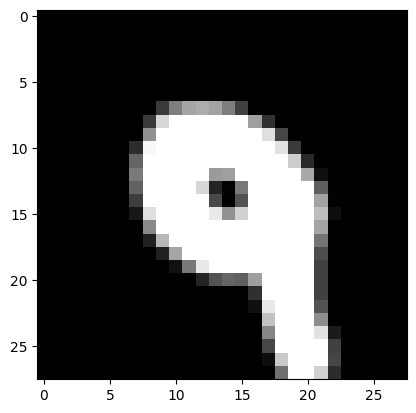

Predicted : 9 - Confidence: 56.30%
True label: 9


In [13]:
sampling_idx = torch.randint(0, len(images), (1,))
test_img = images[sampling_idx]
test_label = labels[sampling_idx]
plt.imshow(test_img.numpy().squeeze(), cmap="grey")
plt.show()
predicted_number, confidence = predict_digit(test_img, model)
print(f"Predicted : {predicted_number} - Confidence: {100*confidence:.2f}%")
print(f"True label: {test_label.item()}")

### Metrics

Does it look good?

Since this is just one image from the **training** dataset, we need to evaluate how the model performs on data it has never seen before. This is where the **test** dataset comes in. In the following cell, we calculate various metrics to evaluate the model's performance.

The metrics we will calculate are Accuracy, Recall, F1 score, and Support:

- **Accuracy**: The ratio of correctly predicted instances to the total instances. It gives an overall measure of how well the model is performing.
- **Recall**: The ratio of correctly predicted positive observations to all the observations in the actual class. It tells us how well the model can identify positive instances.
- **F1 Score**: The weighted average of Precision and Recall. It is useful when you need a balance between Precision and Recall.
- **Support**: The number of actual occurrences of the class in the dataset. It helps in understanding the distribution of the dataset.

When interpreting these metrics, keep in mind:
- **Accuracy** can be misleading if the dataset is imbalanced.
- **Recall** is crucial when the cost of false negatives is high.
- **F1 Score** is useful when you need to balance Precision and Recall.
- **Support** helps in understanding the context of the other metrics.


Evaluating the model on the Test set:   0%|          | 0/157 [00:00<?, ?it/s]

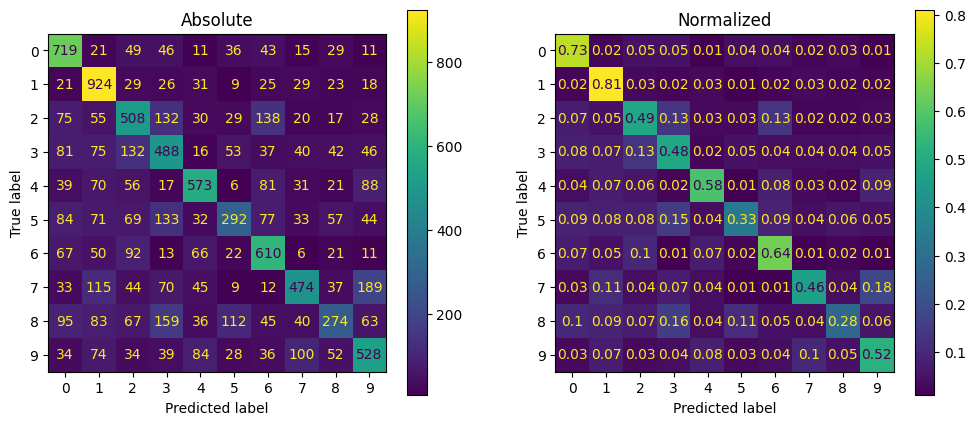

              precision    recall  f1-score   support

           0       0.58      0.73      0.65       980
           1       0.60      0.81      0.69      1135
           2       0.47      0.49      0.48      1032
           3       0.43      0.48      0.46      1010
           4       0.62      0.58      0.60       982
           5       0.49      0.33      0.39       892
           6       0.55      0.64      0.59       958
           7       0.60      0.46      0.52      1028
           8       0.48      0.28      0.35       974
           9       0.51      0.52      0.52      1009

    accuracy                           0.54     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.54      0.53     10000



In [14]:
model.to(device)
model.eval()

test_predicted_output = []
test_true_output = []

with torch.no_grad():
    for batch_idx, (image_batch, output_batch) in enumerate(
        tqdm(test_loader, desc="Evaluating the model on the Test set")
    ):
        image_batch, output_batch = image_batch.to(device), output_batch.to(device)
        model_output = model(image_batch)
        predicted_numbers = torch.argmax(model_output, dim=1)
        test_predicted_output.extend(predicted_numbers.cpu().numpy())
        test_true_output.extend(output_batch.cpu().numpy())

cm_abs = sklearn.metrics.confusion_matrix(
    test_true_output, test_predicted_output, labels=[i for i in range(10)]
)
cm_norm = sklearn.metrics.confusion_matrix(
    test_true_output,
    test_predicted_output,
    labels=[i for i in range(10)],
    normalize="true",
)
cm_round = np.around(cm_norm, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

disp_abs = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm_abs, display_labels=[i for i in range(10)]
)
disp_norm = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm_round, display_labels=[i for i in range(10)]
)

classification_report_test = sklearn.metrics.classification_report(
    test_true_output, test_predicted_output, labels=[i for i in range(10)]
)

disp_abs.plot(ax=ax1)
ax1.set_title("Absolute")
ax1.grid(False)

disp_norm.plot(ax=ax2)
ax2.set_title("Normalized")
ax2.grid(False)
plt.show()

print(classification_report_test)

With a simple CNN and augmented data, the metrics tend to be lower than in the other notebooks. You can add another epoch, which might improve the scores. Nonetheless, let us see how well the model performs on your hand-written digits.

## Model Export

In [15]:
FILE_NAME = "./2_augmented_mnist_model.onnx"

MODEL_FOLDER = Path.cwd() / "models"
MODEL_PATH = MODEL_FOLDER / FILE_NAME

# Create the directory if it doesn't exist
if not MODEL_FOLDER.exists():
    MODEL_FOLDER.mkdir(parents=True, exist_ok=True)
    print(f"Directory '{MODEL_FOLDER}' created.")
else:
    print(f"Directory '{MODEL_FOLDER}' already exists.")

Directory 'c:\Users\TobiasRothlin\Documents\Python_Projects\ComputerVisionTurtorial\models' already exists.


In [16]:
# Save the model
model.eval()
image = images[0].unsqueeze(0)
torch.onnx.export(
    model, image, MODEL_PATH, input_names=["image"], output_names=["digit"]
)

print(f"Model exported in ONNX format to: {MODEL_PATH}")

Model exported in ONNX format to: c:\Users\TobiasRothlin\Documents\Python_Projects\ComputerVisionTurtorial\models\2_augmented_mnist_model.onnx


## Real-world Data

Most tutorials would just finish with the above evaluation. After all, the metrics look quite good, the majority of the manually provided samples to the model are correctly classified; what more do you want?

What is mostly missing, but what is the most common problem in practice, is, that there are real-world cases with real-world data. The model is performing quite well, but what if you provide completely novel hand-written digits to it that is maybe not nicely centred, or is drawn with a different pencil width, or rotated, etc.

In the following section, we add this real-world scenario by letting you draw your own hand-written digits and test your trained models against this custom dataset.

### Single Digit

To create a single digit that can be run in the `Real-World Model Inference` below:
1. Open the drawing tool to create hand-written digits yourself by running the next cell
1. Select the model you just created
1. Draw a digit
1. Click on 'Classify' to see how well the model predicts
1. Close the tool (or try more digits)

#### Custom Digits Test Dataset

To create a suite of digits ranging from 0 to 9 that can be run in the `Real-World Digits Comparison` below:
1. Open the drawing tool to create hand-written digits yourself by running the next cell
1. Click on `Create Custom Test Set`
1. Draw the digit that is prompted
1. Click on `Save and Next`
1. Once done you can change any drawn number by selecting it from the dropdown

In [17]:
!python src/model_test_drawing.py

Predicted number: 6, Confidence: 0.9293
Predicted number: 3, Confidence: 0.2765
Predicted number: 6, Confidence: 0.2564
Predicted number: 1, Confidence: 0.4478
Predicted number: 1, Confidence: 0.4478
Predicted number: 1, Confidence: 0.4478
Predicted number: 1, Confidence: 0.4478
Predicted number: 1, Confidence: 0.9403
Predicted number: 1, Confidence: 0.9403
Predicted number: 6, Confidence: 0.7426
Predicted number: 1, Confidence: 0.7311
Predicted number: 1, Confidence: 0.7131


### Real-World Model Inference

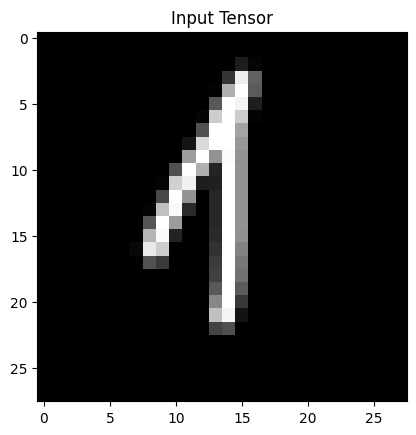

PyTorch model prediction: 1 - Confidence: 71.31%
ONNX model prediction:    1 - Confidence: 71.31%


In [18]:
assert (
    Path.cwd() / "handwriting" / "my_digit.npy"
).exists(), "Draw and classify a digit first."
image_input_tensor = np.load("handwriting/my_digit.npy")

plt.cla()
plt.imshow(image_input_tensor[0].squeeze(), cmap="grey")
plt.title("Input Tensor")
plt.show()

try:
    model.eval()
    pt_predicted_number, pt_confidence = predict_digit(
        torch.tensor(image_input_tensor), model
    )
    print(
        f"PyTorch model prediction: {pt_predicted_number} - Confidence: {100*pt_confidence:.2f}%"
    )
except NameError:
    print("No PyTorch model present, skipping...")

onnx_predicted_number, onnx_confidence = predict_digit(
    image_input_tensor, onnx=True, onnx_model_path=MODEL_PATH
)
print(
    f"ONNX model prediction:    {onnx_predicted_number} - Confidence: {100*onnx_confidence:.2f}%"
)

#### Real-World Digits Comparison

The plot lets you compare the performance of all the models from the following notebooks (they will have the same output, just with their model).

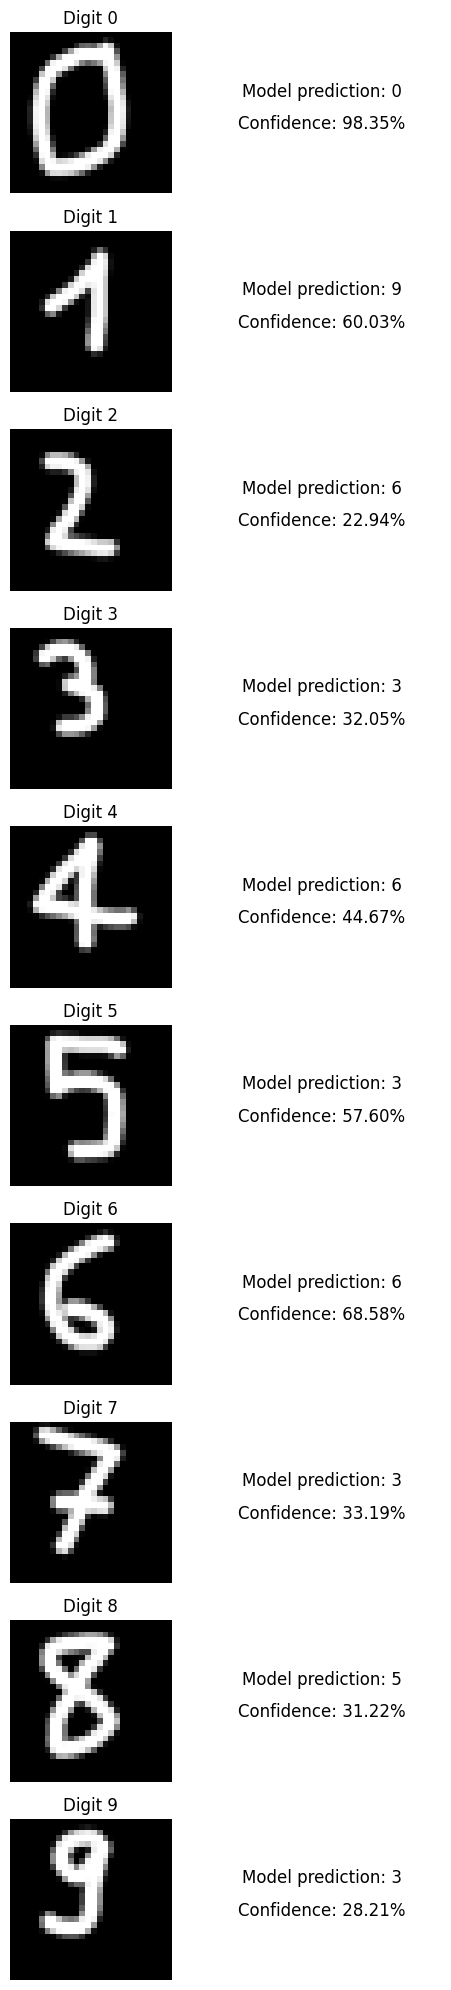

In [19]:
assert (
    Path.cwd() / "handwriting" / "digit_0.npy"
).exists(), "Draw and classify a digit first."
directory_path = Path("handwriting/")

fig, axes = plt.subplots(10, 2, figsize=(5, 20))

for i in range(10):
    file_path = directory_path / f"digit_{i}.npy"
    image_input_tensor = np.load(file_path)

    axes[i, 0].imshow(image_input_tensor.squeeze(), cmap="gray")
    axes[i, 0].set_title(f"Digit {i}")
    axes[i, 0].axis("off")

    onnx_predicted_number, onnx_confidence = predict_digit(
        image_input_tensor, onnx=True, onnx_model_path=MODEL_PATH
    )

    axes[i, 1].text(
        0.5, 0.6, f"Model prediction: {onnx_predicted_number}", fontsize=12, ha="center"
    )
    axes[i, 1].text(
        0.5, 0.4, f"Confidence: {100*onnx_confidence:.2f}%", fontsize=12, ha="center"
    )
    axes[i, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

It seems that even though we augmented the dataset with one or more transformations, the model is still not able to classify well on your drawings.

The model may still be wrong, but hopefully with a lower confidence than the basic model.

In the final notebook, we will address this issue!